<a href="https://colab.research.google.com/github/dominikacecylia/Workshops-ML/blob/main/WarsztatyAalizaSentymentu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

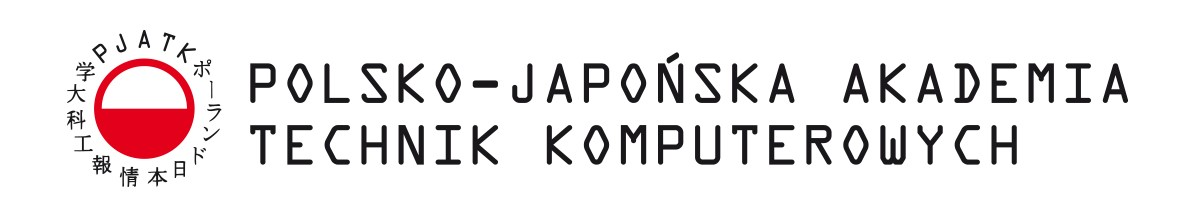


# Analiza sentymentu

**Analiza sentymentu** to klasyfikacja tekstu polegająca na ocenie przez model emocji/intencji zawartej w tekście/wypowiedzi/tweecie etc. Model potrzebuje danych otagowanych, czyli danych, którym przypisano już kategorie. Będzie to zatem *uczenie z nadzorem*.
W dzisiejszym przykładzie zbudujemy model do analizy recenzji filmowych - podziału recencji na nacechowane negatywnie lub pozytywnie.

## Przygotowanie środowiska

Pierwszym krokiem jest przygotowanie środowiska.

Do klasycznego uczenia maszynowego wystarczy zwykłe CPU, GPU będzie potrzebne do głębokich sieci neuronowych. Poniżej przykład, jak najprościej uruchomić GPU w Google Colabie:

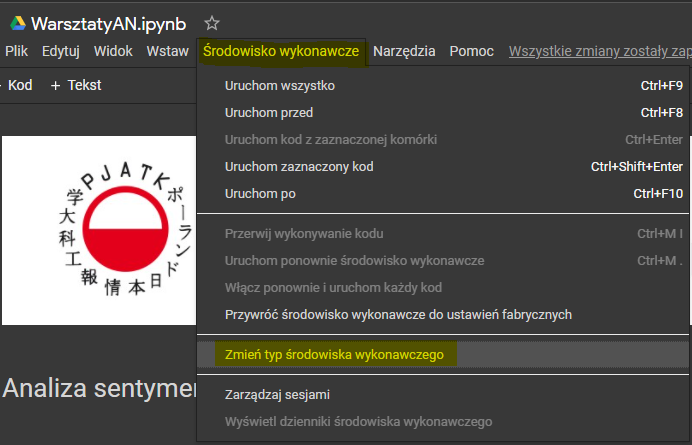

Z paska narzędzi wybieramy `Środowisko wykonawcze > Zmień typ środowiska wykonawczego`, a następnie zmieniamy defaultowe CPU na GPU.

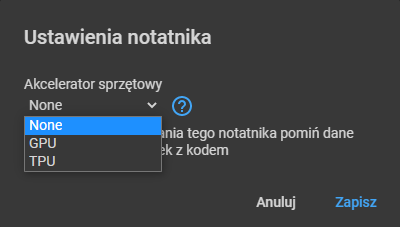

# Analiza Sentymentu z sieciami neuronowymi

### Import bibliotek

In [ ]:
# pomocnicze
import re
import string
import numpy as np
import pandas as pd
import csv

# wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt 

# przygotowanie danych
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess

# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ewaluacja (ocena)
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

## Wczytanie danych

In [ ]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  extract=True, # dawniej untar, boolean, whether the file should be decompressed 
                                  cache_dir='.', # Location to store cached files, when None it defaults to the default directory ~/.keras/
                                  cache_subdir='') 
# funkcja get_file zwraca ścieżkę do ściągniętego pliku

In [ ]:
# Moduł shutil oferuje szereg operacji wysokiego poziomu na plikach i kolekcjach plików.
import os
import shutil

In [ ]:
# Tworzymy główną ścieżkę ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# Tworzymy ścieżkę dla folderu train ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')

# Usuwamy folder z danymi niotagowanymi
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# Wyświetlamy zawartość train dir
print(os.listdir(train_dir))

['urls_neg.txt', 'urls_unsup.txt', 'urls_pos.txt', 'labeledBow.feat', 'neg', 'unsupBow.feat', 'pos']


In [ ]:
# Wczytujemy dane
# korzystamy z folderu  "aclImdb/train"
data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', # lokalizacja z danymi
    batch_size=25000
)

Aby dane były dla nas bardziej czytelne zamienimy obiekt TF na DataFrame z bibloteki pandas.

In [ ]:
for i in data.take(1):
  train_rec = i[0].numpy()
  train_kl = i[1].numpy()

dane_df = pd.DataFrame([train_rec, train_kl]).T
dane_df.columns = ['recenzja', 'klasa']
dane_df['recenzja'] = dane_df['recenzja'].str.decode("utf-8")
dane_df.head()

## Eksploracja danych

In [ ]:
# sprawdź unikalne wartości

In [ ]:
# sprawdź podział danych w klasach

## Pre-processing danych

Kolejnym etapem jest wstępne przetworzenie danych:
* Usunięcie adresów URL z tweetów
* Tokenizacja (podział zdania na słowa)
* Usunięcie e-maili
* Usunięcie znaków nowej linii
* Usunięcie pojedynczych cytatów
* Usunięcie wszystkich znaków interpunkcyjnych
* Normalizacja tekstu
* Usunięcie stopwords
* Detokenizacja (złączenie słów w zdania)
* Zamiana listy na tablicę Numpy

In [ ]:
#sprawdzamy czy nie ma brakujących wartości
dane_df['recenzja'].isnull().sum()

In [ ]:
# to samo dla klas
...

In [ ]:
# #Możemy usunąć wiersze z nullami
# dane_df.dropna(inplace=True)

In [ ]:
# usuwanie znaków specjalnych etc.

## utworz metode czysc dane
...


In [ ]:
temp = []
# Zamiana na listę
dane_to_list = dane_df['recenzja'].values.tolist()

for i in range(len(data_to_list)):
    temp.append(czysc_dane(dane_to_list[i]))
list(temp[:5])

In [ ]:
def podziel_zdanie(zdania):
    for zdanie in zdania:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True usuwa interpunkcję
        

dane_slowa = list(podziel_zdanie(temp))

dane_slowa[:10]

In [ ]:
# usunięcie stopwords
...

In [ ]:
# sklejenie zdań
def zamien_na_zdanie(text):
    return TreebankWordDetokenizer().detokenize(text)

dane = []
for i in range(len(dane_slowa)):
    dane.append(zamien_na_zdanie(dane_slowa[i]))
print(dane[:5])

In [ ]:
# zamień na np array
dane = np.array(dane)

## Zamiana danych na format do obróbki w sieciach

In [ ]:
labels = np.array(dane_df['klasa'])
labels = tf.keras.utils.to_categorical(labels, 2, dtype="float32")

## Zamiana danych na tensory

In [ ]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

In [ ]:
print(labels)

In [ ]:
# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

## Budowa modelu

Model zbudujemy na kilku typach sieci neuronowych:
* LSTM
* CNN

## Single LSTM layer model

In [ ]:
model1 = 

In [ ]:
model1.add(...)

In [ ]:
model1.add(...)

In [ ]:
model1.add(...)

In [ ]:
# wyświetl budowę modelu

In [ ]:
model1.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [ ]:
#Checkpints pozwalają nam zachować model w konkretnym punkcie i później znów go wczytać
checkpoint1 = ModelCheckpoint("najlepszy_model1.hdf5", 
                              monitor='val_accuracy', # metryka wyświetlana
                              verbose=1, # 0 lub 1, jak dużo informacji będzie wyświetlanych
                              save_best_only=True, # zachowa tylko najlepszy model
                              mode='auto', # dotyczy nadpisywania przy zapisie najlepszego modelu
                              save_weights_only=False)

In [ ]:
# trening modelu

## 1D Convolutional model

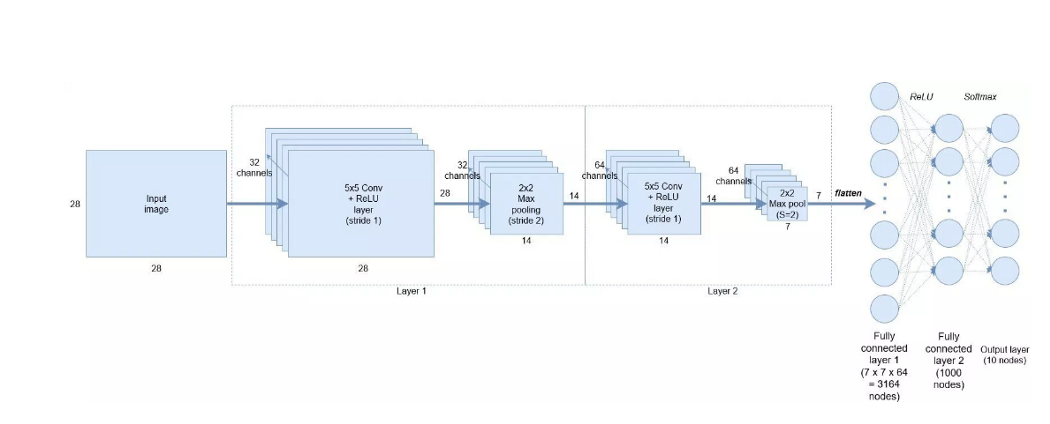

In [ ]:
from keras import regularizers
model2 = Sequential()

In [ ]:
model2.add(layers.Embedding(max_words, 40, input_length=max_len))

In [ ]:
model2.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))

In [ ]:
model2.add(layers.MaxPooling1D(5))

In [ ]:
model2.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))

In [ ]:
model2.add(layers.GlobalMaxPooling1D())

In [ ]:
model2.add(layers.Dense(2,activation='softmax'))

In [ ]:
model2.summary()

In [ ]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
checkpoint2 = ModelCheckpoint("najlepszy_model3.hdf5",
                              monitor='val_accuracy', 
                              verbose=1,
                              save_best_only=True,
                              mode='auto', 
                              save_weights_only=False)
history = model2.fit(X_train, 
                     y_train, 
                     epochs=20,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint2])

## Ewaluacja najlepszego modelu

In [ ]:
# ładujemy najlepszy model
najlepszy_model = ...

In [ ]:
_, test_acc = najlepszy_model.evaluate(X_test, y_test, verbose=2)
print('Dokładność modelu: ', test_acc)

In [ ]:
predykcje = ...

## Confusion matrix

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predykcje, decimals=0).argmax(axis=1))

In [ ]:
conf_matrix = pd.DataFrame(matrix, index = ['Negatywny','Pozytywny'],columns = ['Negatywny','Pozytywny'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 10})

In [ ]:
opinia = ['Negatywny','Pozytywny']

In [ ]:
# ocena wybranych recenzji

In [ ]:
# 'this experience has been the worst , want my money back'
...

In [ ]:
# 'this data science article is the best ever'
...

In [ ]:
# 'i hate youtube ads, they are annoying'
...

In [ ]:
# 'i really loved how the technician helped me with the issue that i had'
...